In [ ]:
!pip install neo4j
from neo4j import GraphDatabase
driver = GraphDatabase.driver("uri", auth=("neo4j", "password"))

uri =       "uri"
username =  "username"
password =  "password"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.9/311.9 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
!pip install python-louvain
import networkx as nx
import community
from community import community_louvain
import matplotlib.pyplot as plt

layout_algorithms = [
    nx.circular_layout,
    nx.random_layout,
    nx.spring_layout,
    nx.spectral_layout,
    nx.shell_layout,
    nx.bipartite_layout,
    nx.planar_layout,
    nx.fruchterman_reingold_layout,
    nx.kamada_kawai_layout
]

A=['PGM1-CDG','Cerebral cavernous malformations 3',"CLOVES syndrome","STT3B-CDG","Thoracolaryngopelvic dysplasia","Actinic prurigo","Non-syndromic polydactyly","Genitopatellar syndrome","Diaphanospondylodysostosis"]
B=['GARD0004329','GARD0018314',"GARD0010939","GARD0017603","GARD0005184", "GARD0017510","GARD0004410","GARD0010994","GARD0016674"]
for n in range(len(A)):
  disease= A[n]  #'Actinic prurigo' #'Non-syndromic polydactyly'   #'Cystic fibrosis'
  diseaseid=B[n]

In [ ]:
def get_cluster(disease):
 with driver.session() as session:
  query = "MATCH (i:Researcher)--(C:Cluster)--(g:Gard) where g.GARDname= $disease  RETURN i.Name + ', @institution: ' + i.Aff_name as researcher,  C.Cluster_ID "
  results = session.run(query, disease=disease)
  data = [record.data() for record in results]  # Convert result to a list of dictionaries
  resercher_cluster = pd.DataFrame(data)
  cluster_info={}
  for i in resercher_cluster.index:
    #if type(resercher_cluster['i.Name'][i]) ==str:
        #cluster_info[resercher_cluster['i.Name'][i]+', @institution: '+str(  resercher_cluster['i.Aff_name'][i])  ]   =  int(resercher_cluster['C.Cluster_ID'][i])+2
        cluster_info[resercher_cluster['researcher'][i]  ]   =  int(resercher_cluster['C.Cluster_ID'][i])+2

  return cluster_info



def get_reseracher_info(disease):
 with driver.session() as session:
  query = "MATCH (i:Researcher)--(C:Cluster)--(g:Gard) WHERE g.GARDname=$disease OPTIONAL MATCH (i)-[:Collaborated_With]-(n:Researcher)  WITH i, COLLECT(n.Name + ', @institution: ' + n.Aff_name) AS collaborators RETURN i.Name + ', @institution: ' + i.Aff_name AS researcher, collaborators "
  results = session.run(query, disease=disease)
  data = [record.data() for record in results]  # Convert result to a list of dictionaries
  reseracher_info = pd.DataFrame(data)
 return reseracher_info


def get_expertise_info(disease):
 driver = GraphDatabase.driver("neo4j+s://61c58777.databases.neo4j.io", auth=("neo4j", "dxAygWQGb5sHpMKuCpEezn7b2sLujbBTN2Y2CldwzJc"))
 with driver.session() as session:
  query = "MATCH (C:Cluster)--(g:Gard) WHERE g.GARDname = $disease OPTIONAL MATCH (C)--(i:Expertise) WITH   C,   toInteger(C.Cluster_ID)+2  AS updatedClusterID,  apoc.text.join(collect(i.Summarized_expertise), ', ') AS expertiseList,  count(i) AS expertiseCount RETURN  updatedClusterID, CASE  WHEN expertiseCount = 0 THEN C.Key_trems ELSE expertiseList END AS expertiseOrKeyTerms"
  results = session.run(query, disease=disease)
  data = [record.data() for record in results]  # Convert result to a list of dictionaries
  expertise_info = pd.DataFrame(data)
  expertise={}
  for i in expertise_info.index:
       expertise[expertise_info['updatedClusterID'][i]]= expertise_info['expertiseOrKeyTerms'][i]
                                                        #', '.join([i.strip() for i in  expertise_info['expertiseOrKeyTerms'][i].split(',') if len(i.strip().split(' '))>2])
 return expertise



'congenital disorder of glycosylation, phosphoglucomutase 1 deficiency'

# Digraph

In [ ]:
import pandas as pd
disease='PGM1-CDG'
cluster_info=get_cluster(disease)
reseracher_info=get_reseracher_info(disease)
expertise=get_expertise_info(disease)
#cluster_info
#reseracher_info

G = nx.DiGraph()
# Add nodes and edges from the dictionary
for i in reseracher_info.index:
    new_node = reseracher_info['researcher'][i]
    if new_node not in G:
        G.add_node(new_node)
    collab = reseracher_info['collaborators'][i]
    for edge in collab:
        if edge not in G:
            G.add_node(edge)
        if not G.has_edge(new_node, edge):
            G.add_edge(new_node, edge)
partition= cluster_info
nodes_to_remove = [node for node, attr in G.nodes(data=True) if node not in cluster_info]
display(len(nodes_to_remove))
for node in nodes_to_remove:
    if node in G:
        G.remove_node(node)

13

<ipython-input-5-67f8bf9dc1d9>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map


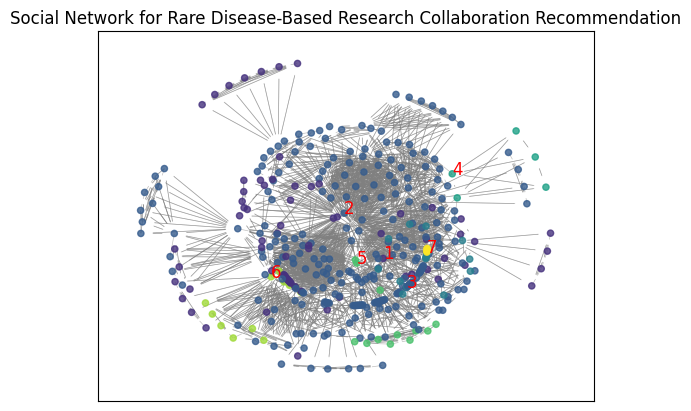

In [ ]:
pos = nx.kamada_kawai_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=[cmap(partition[node]) for node in G.nodes()], alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)

# Label one node per community with its community partition value near its community
community_labels = {}
for node, community_id in partition.items():
    if community_id not in community_labels:
        community_labels[community_id] = node

for community_id, node in community_labels.items():
    x, y = pos[node]
    plt.text(x, y, str(community_id), fontsize=12, color='red')

plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
plt.show()

# Graph

<ipython-input-37-8b42586c26a2>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


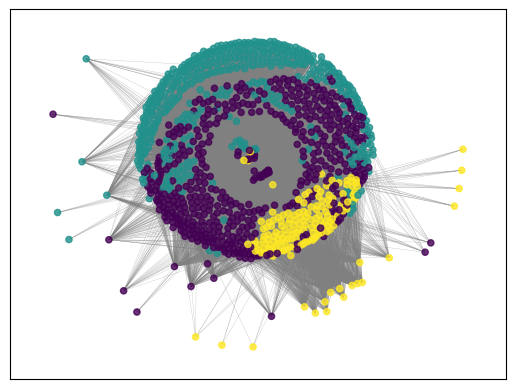

In [ ]:
#cluster_info=get_cluster(disease)
reseracher_info= pd.read_csv('/content/reseracher_info.csv')#  get_reseracher_info(disease)
reseracher_info=reseracher_info[:1000]
#expertise=get_expertise_info(disease)

 # Create a directed graph
G = nx.Graph()

for i in reseracher_info.index:
    new_node = reseracher_info['researcher'][i]
    if new_node not in G:
        G.add_node(new_node)
    collab = reseracher_info['collaborators'][i]
    for edge in collab:
        if edge not in G:
            G.add_node(edge)
        if not G.has_edge(new_node, edge):
            G.add_edge(new_node, edge)


 # Draw the graph with nodes colored by their community
 #pos = nx.kamada_kawai_layout(G)
 #cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)

partition = community_louvain.best_partition(G)
pos = nx.kamada_kawai_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
node_colors = [cmap(partition[node]) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors,  alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.2, alpha=0.6)


0


<ipython-input-44-afb96b1e0dc6>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


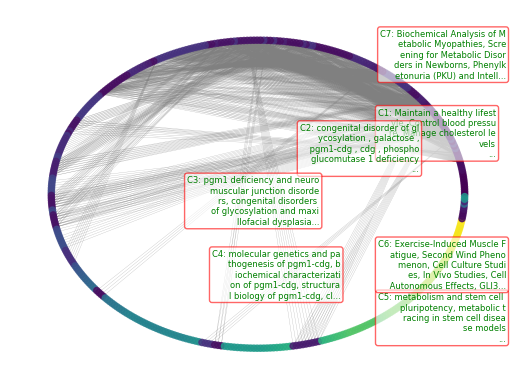

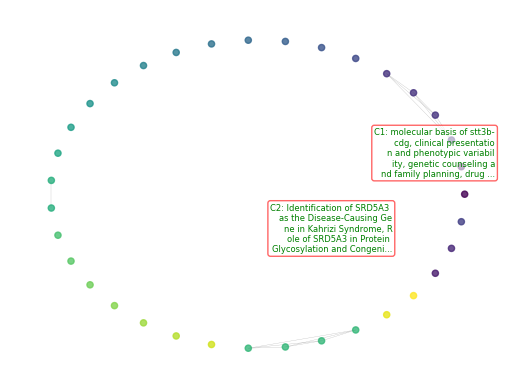

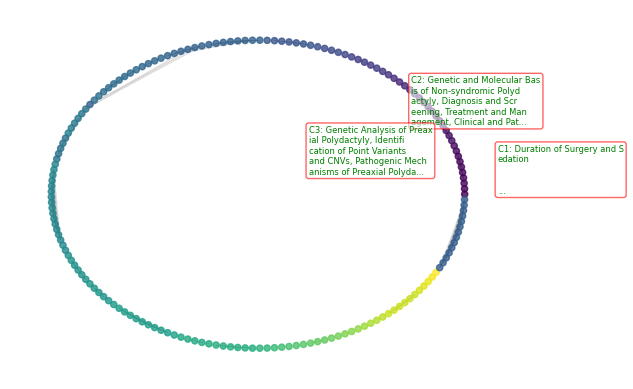

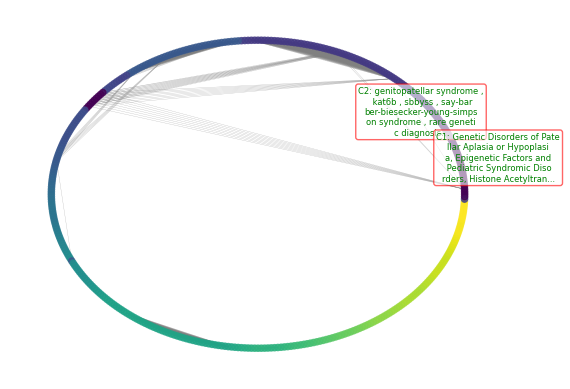

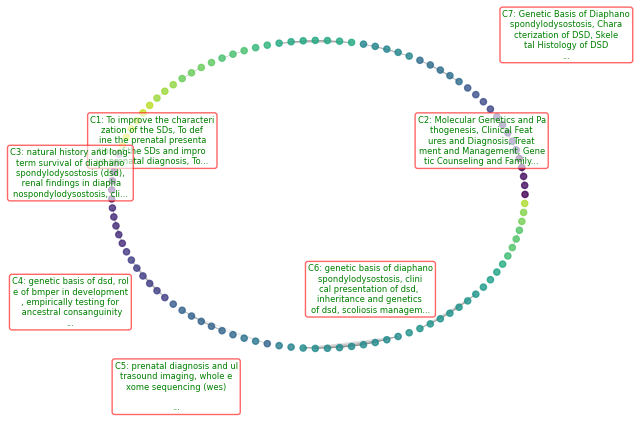

1


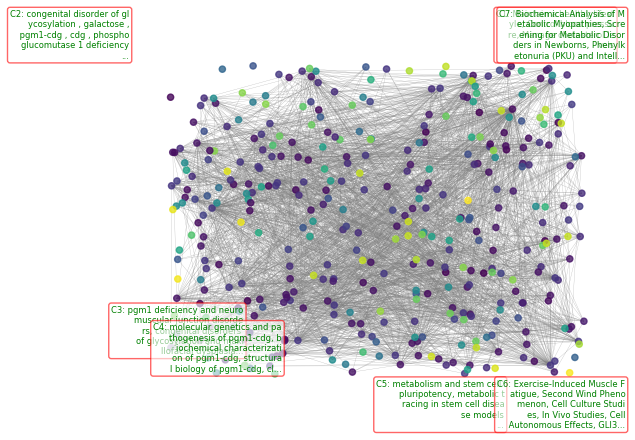

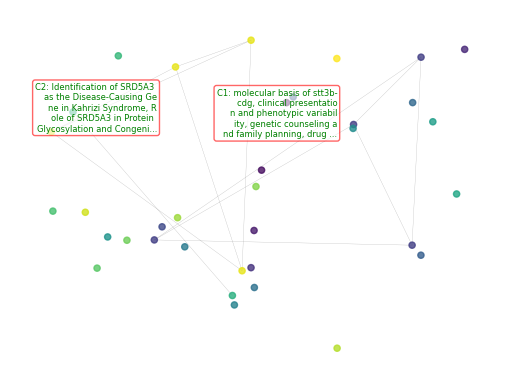

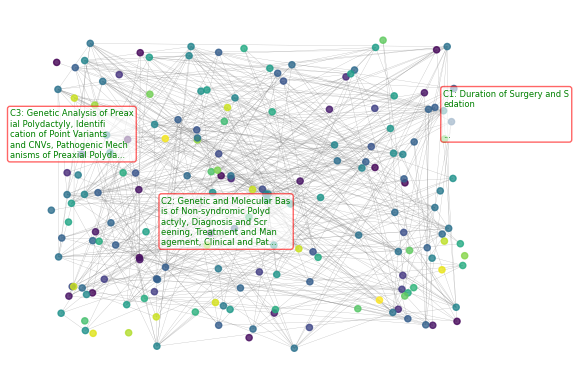

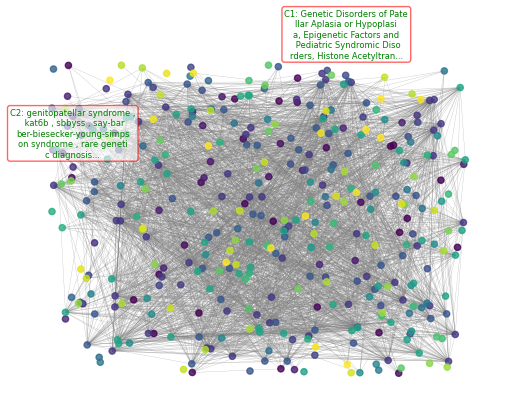

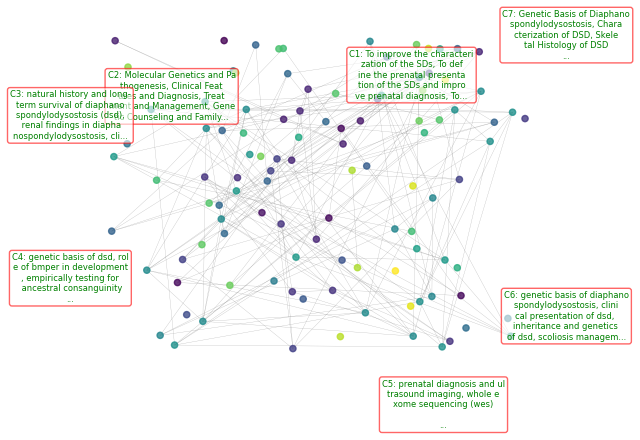

2


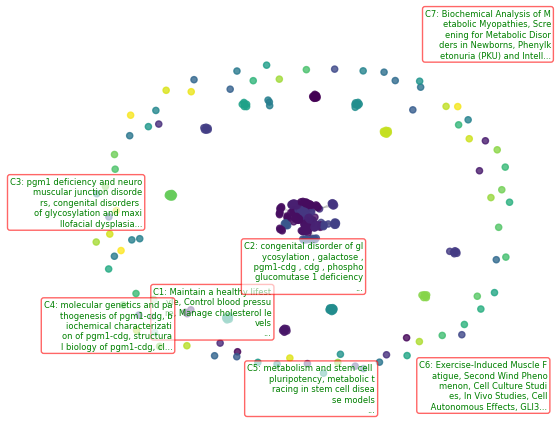

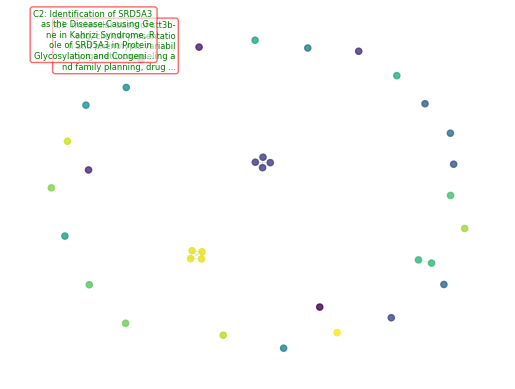

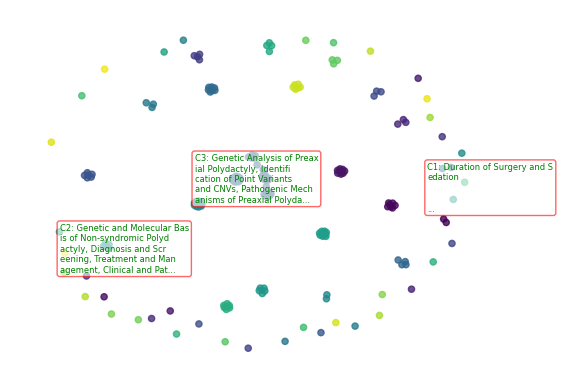

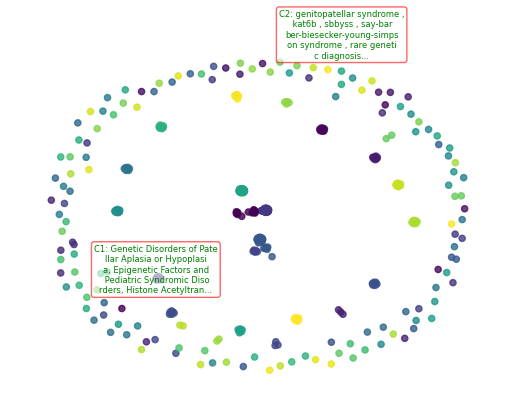

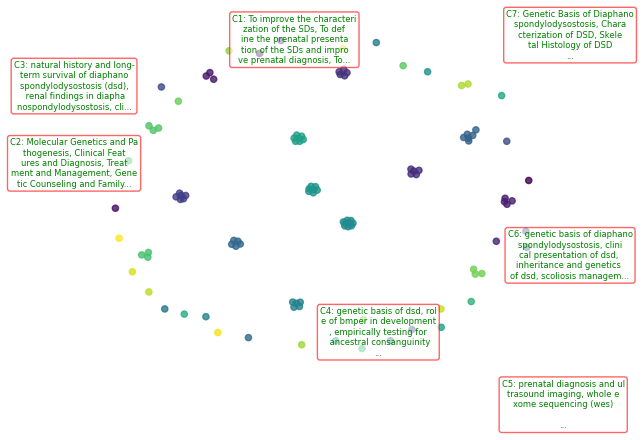

3


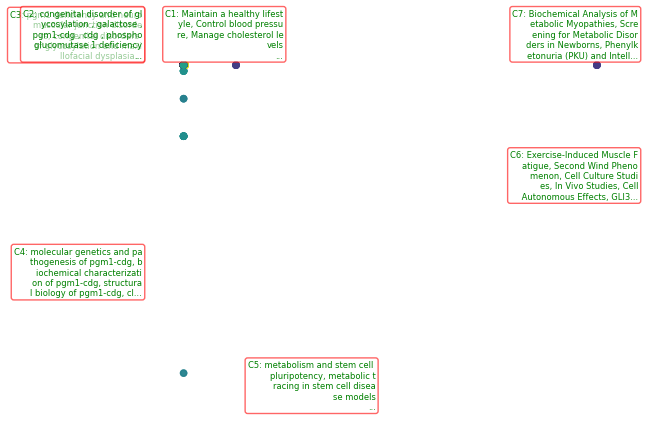

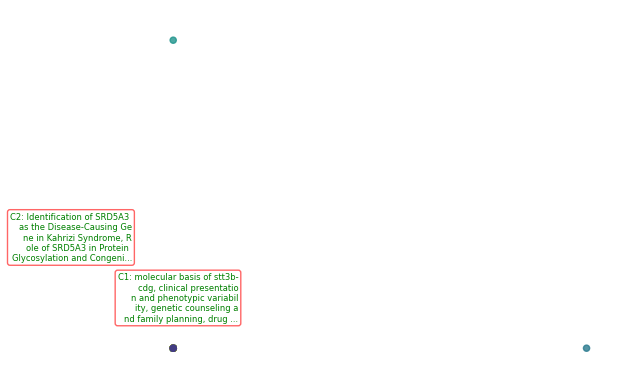

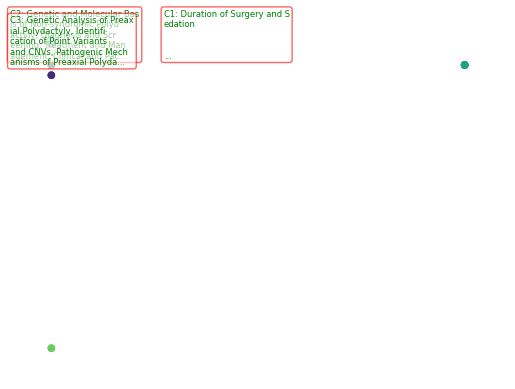

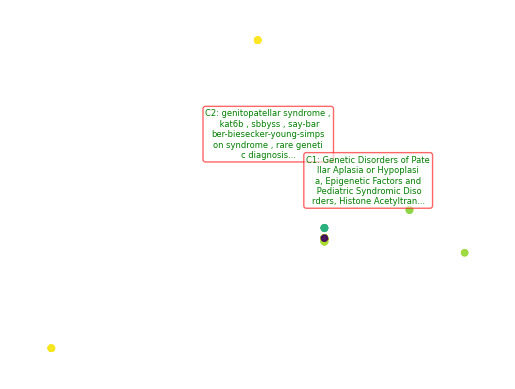

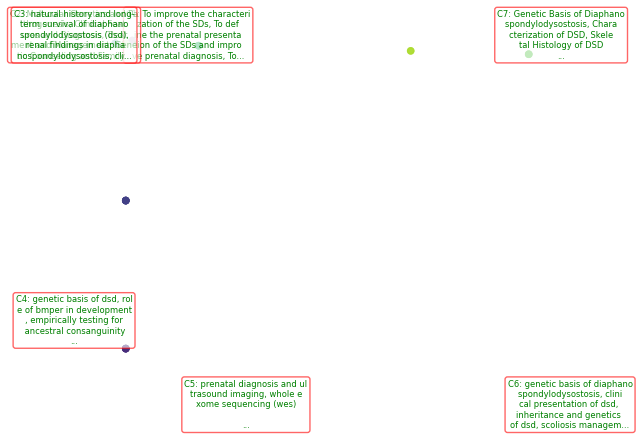

4


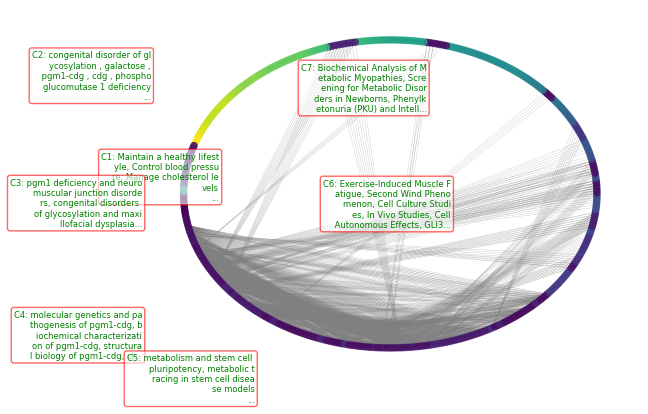

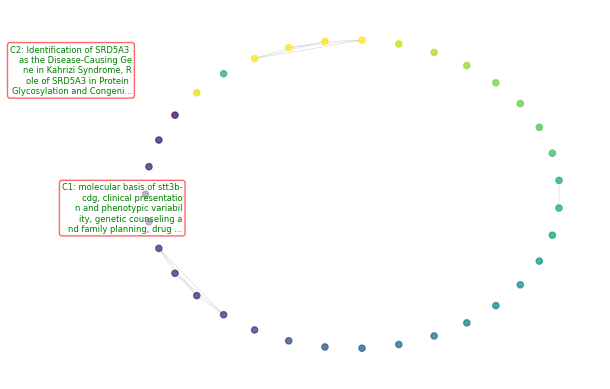

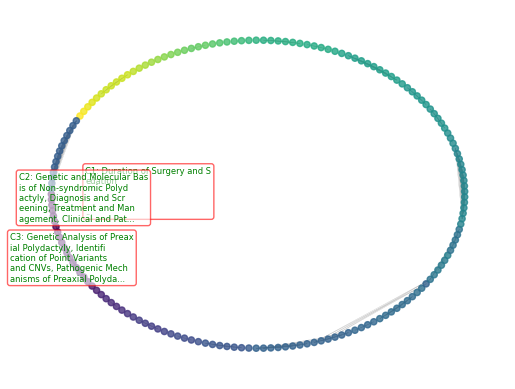

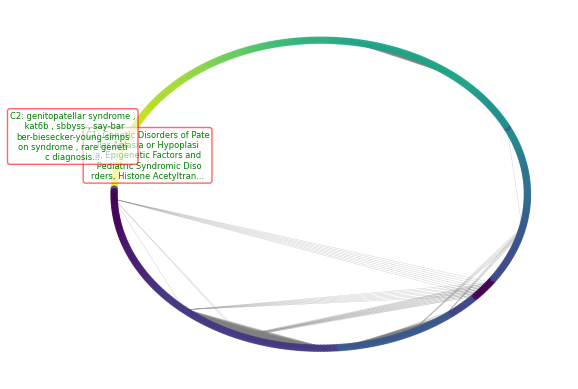

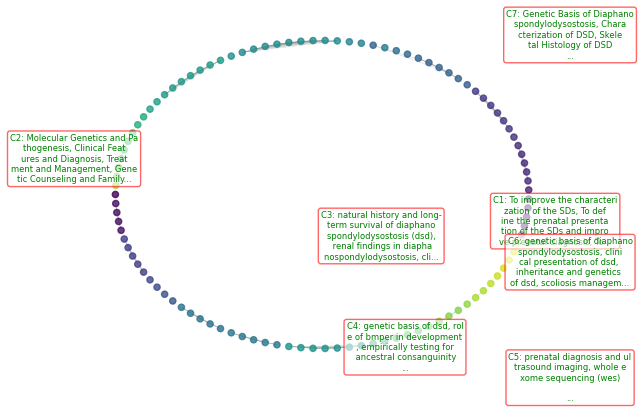

5


TypeError: bipartite_layout() missing 1 required positional argument: 'nodes'

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
A=['PGM1-CDG','Cerebral cavernous malformations 3',"CLOVES syndrome","STT3B-CDG","Thoracolaryngopelvic dysplasia","Actinic prurigo","Non-syndromic polydactyly","Genitopatellar syndrome","Diaphanospondylodysostosis"]
#'PGM1-CDG',   "STT3B-CDG"   , 'Actinic prurigo' remove 1,
#"Non-syndromic polydactyly","Genitopatellar syndrome","Diaphanospondylodysostosis"

disease="Diaphanospondylodysostosis"
def draw_graph(disease,num_layer, HA="center", VA="center"):
 cluster_info=get_cluster(disease)
 reseracher_info=get_reseracher_info(disease)
 expertise=get_expertise_info(disease)

 # Create a directed graph
 G = nx.Graph()

 for i in reseracher_info.index:
    new_node = reseracher_info['researcher'][i]
    if new_node not in G:
        G.add_node(new_node)
    collab = reseracher_info['collaborators'][i]
    for edge in collab:
        if edge not in G:
            G.add_node(edge)
        if not G.has_edge(new_node, edge):
            G.add_edge(new_node, edge)

 partition = cluster_info
 nodes_to_remove = [node for node, attr in G.nodes(data=True) if node not in cluster_info]
 for node in nodes_to_remove:
    if node in G:
        G.remove_node(node)

 # Draw the graph with nodes colored by their community
 #pos = nx.kamada_kawai_layout(G)
 #cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)

 partition = community_louvain.best_partition(G)
 pos = layout_algorithms[num_layer](G)  #nx.kamada_kawai_layout(G)
 cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
 node_colors = [cmap(partition[node]) for node in G.nodes()]
 nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors,  alpha=0.8)


 #pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)
 #cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
 #node_colors = [cmap(partition[node]) for node in G.nodes()]
 #nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors, alpha=0.8)


 #nx.draw_networkx_nodes(G, pos, node_size=20, node_color=[cmap(partition[node]) for node in G.nodes()], alpha=0.8)
 nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.2, alpha=0.6)

 # Label one node per community
 community_labels = {}
 for node, community_id in partition.items():
    if community_id not in community_labels:
        community_labels[community_id] = node

 # Set figure limits
 x_vals, y_vals = zip(*pos.values())
 x_min, x_max = min(x_vals), max(x_vals)
 y_min, y_max = min(y_vals), max(y_vals)
 x_margin = (x_max - x_min)*0.1 #* 0.3
 y_margin = (y_max - y_min)*0.1 #* 0.3

 #ax.set_frame_on(False)  # Disable figure border
 plt.axis('off')
 # Organize labels to avoid overlaps
 for community_id, node in community_labels.items():
  #if community_id>1:
    x, y = pos[node]

    # Apply an offset for the labels
    offset = 0.1 + 0.2 * community_id
    x_label = x + offset * np.cos(community_id)
    y_label = y + offset * np.sin(community_id)

    # Clamp label positions within the figure bounds
    x_label = max(x_min - x_margin, min(x_max + x_margin, x_label))
    y_label = max(y_min - y_margin, min(y_max + y_margin, y_label))

    # Display label with expertise information
    try:
        label_text = (
            f"C{community_id}: {expertise[community_id][:25]}\n"
            f"{expertise[community_id][25:50]}\n"
            f"{expertise[community_id][50:75]}\n"
            f"{expertise[community_id][75:100]}\n"
            f"{expertise[community_id][100:125]}..."
        )
        plt.text(
            x_label, y_label, label_text, fontsize=6, color="green", ha=HA, va=VA,
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="red", boxstyle="round,pad=0.3")
        )
    except:
        pass

 # Finalize plot
 #plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
 plt.xlim(x_min - x_margin, x_max + x_margin)
 plt.ylim(y_min - y_margin, y_max + y_margin)
 #plt.xlim(x_min, x_max )
 #plt.ylim(y_min , y_max )
 plt.show()
A=['PGM1-CDG','Cerebral cavernous malformations 3',"CLOVES syndrome","STT3B-CDG","Thoracolaryngopelvic dysplasia","Actinic prurigo","Non-syndromic polydactyly","Genitopatellar syndrome","Diaphanospondylodysostosis"]
#'PGM1-CDG',   "STT3B-CDG"   , 'Actinic prurigo' remove 1,
#"Non-syndromic polydactyly","Genitopatellar syndrome","Diaphanospondylodysostosis"

disease="Diaphanospondylodysostosis"
for i in range(10):
 if i != 5:
  num_layer=i
  print(i)
  draw_graph('PGM1-CDG', num_layer,HA="right", VA="center")
  draw_graph( "STT3B-CDG",num_layer, HA="right", VA="top")
  draw_graph("Non-syndromic polydactyly",num_layer, HA="left", VA="top")
  draw_graph("Genitopatellar syndrome",num_layer, HA="center", VA="center")
  draw_graph("Diaphanospondylodysostosis",num_layer, HA="center", VA="top")

<ipython-input-30-8cba142cb11f>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


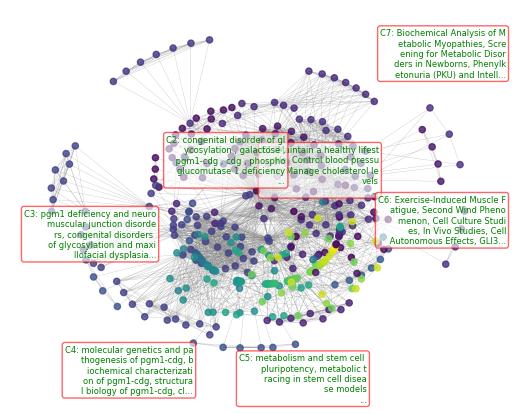

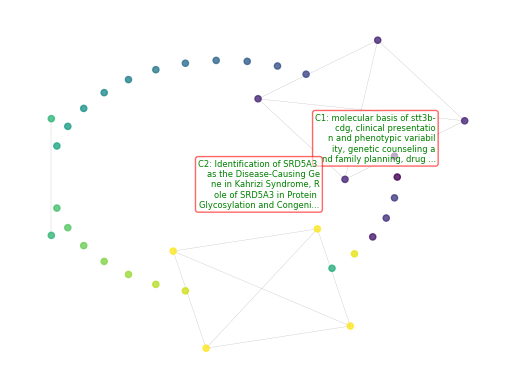

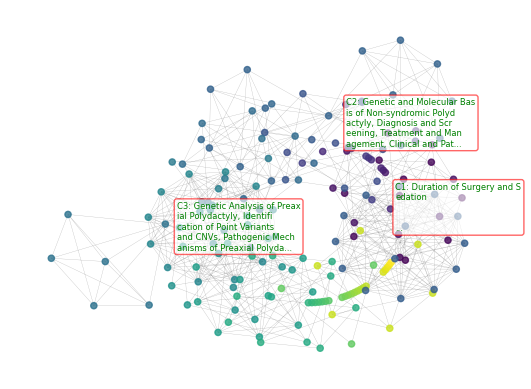

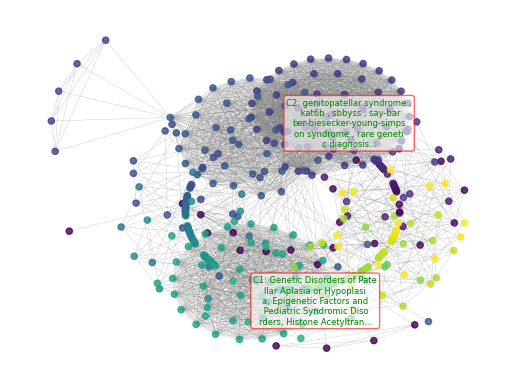

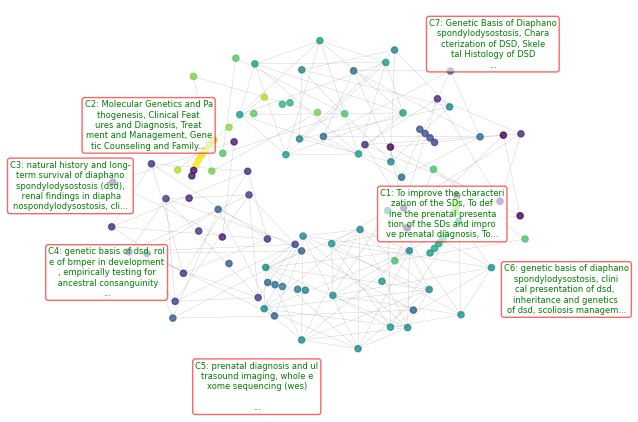

<ipython-input-39-64cb85451f3f>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


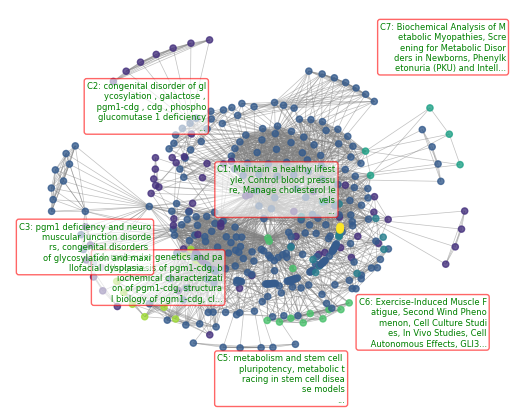

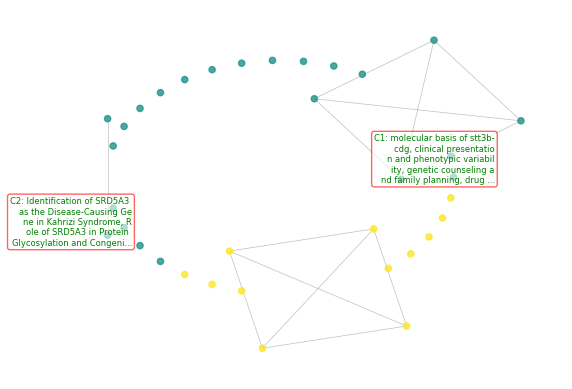

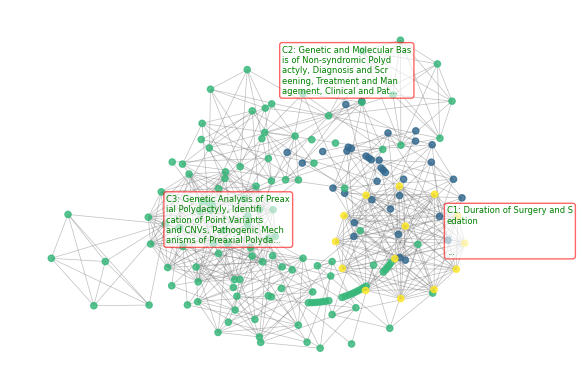

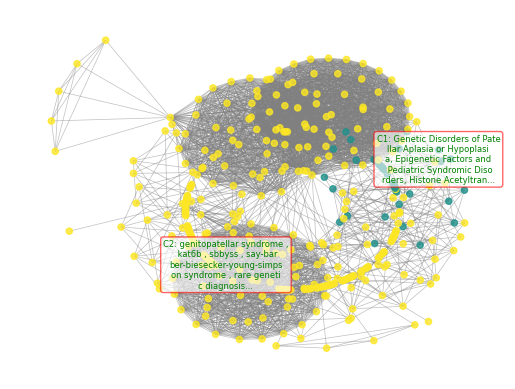

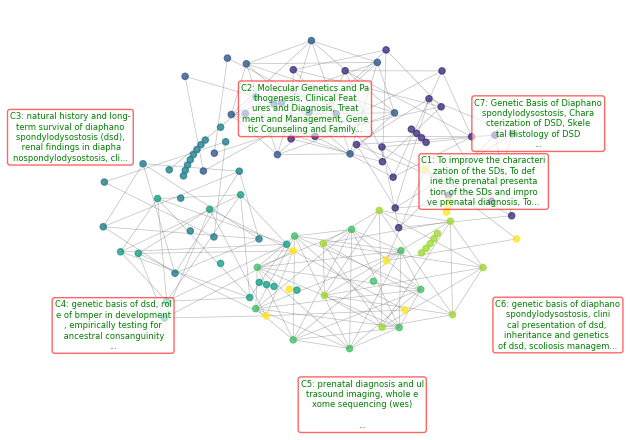

In [ ]:
A=['PGM1-CDG','Cerebral cavernous malformations 3',"CLOVES syndrome","STT3B-CDG","Thoracolaryngopelvic dysplasia","Actinic prurigo","Non-syndromic polydactyly","Genitopatellar syndrome","Diaphanospondylodysostosis"]
#'PGM1-CDG',   "STT3B-CDG"   , 'Actinic prurigo' remove 1,
#"Non-syndromic polydactyly","Genitopatellar syndrome","Diaphanospondylodysostosis"

disease="Diaphanospondylodysostosis"
draw_graph('PGM1-CDG', HA="right", VA="center")
draw_graph( "STT3B-CDG", HA="right", VA="top")
draw_graph("Non-syndromic polydactyly", HA="left", VA="top")
draw_graph("Genitopatellar syndrome", HA="center", VA="center")
draw_graph("Diaphanospondylodysostosis", HA="center", VA="top")

<ipython-input-6-d73a94047be7>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


NameError: name 'np' is not defined

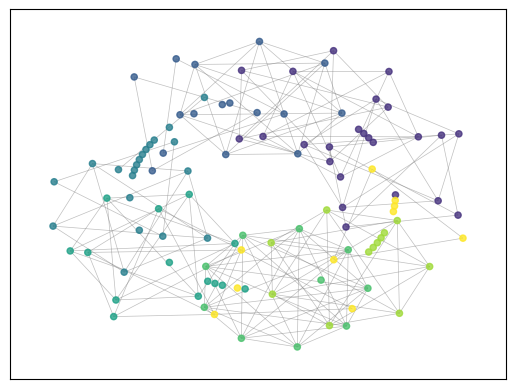

In [ ]:
#'PGM1-CDG',   "STT3B-CDG"   , 'Actinic prurigo' remove 1,
#"Non-syndromic polydactyly","Genitopatellar syndrome","Diaphanospondylodysostosis"
disease="Diaphanospondylodysostosis"
cluster_info=get_cluster(disease)
reseracher_info=get_reseracher_info(disease)
expertise=get_expertise_info(disease)

# Create a graph
G = nx.Graph()

for i in reseracher_info.index:
    new_node = reseracher_info['researcher'][i]
    if new_node not in G:
        G.add_node(new_node)
    collab = reseracher_info['collaborators'][i]
    for edge in collab:
        if edge not in G:
            G.add_node(edge)
        if not G.has_edge(new_node, edge):
            G.add_edge(new_node, edge)

# Remove nodes not in cluster_info
partition = cluster_info
nodes_to_remove = [node for node, attr in G.nodes(data=True) if node not in cluster_info]
for node in nodes_to_remove:
    if node in G:
        G.remove_node(node)

# Draw the graph
pos = nx.kamada_kawai_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=[cmap(partition[node]) for node in G.nodes()], alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.5, alpha=0.5)

# Calculate cluster centers
community_positions = {}
for node, community_id in partition.items():
    if community_id not in community_positions:
        community_positions[community_id] = []
    community_positions[community_id].append(pos[node])

# Draw cluster labels
for community_id, positions in community_positions.items():
    # Calculate the centroid of the community
    x_coords, y_coords = zip(*positions)
    centroid_x, centroid_y = np.mean(x_coords), np.mean(y_coords)

    # Prepare label text
    try:
        label_text = (
            f"C{community_id}: {expertise[community_id][:25]}\n"
            f"{expertise[community_id][25:50]}\n"
            f"{expertise[community_id][50:75]}\n"
            f"{expertise[community_id][75:100]}\n"
            f"{expertise[community_id][100:125]}..."
        )
    except KeyError:
        label_text = f"C{community_id}: No expertise available"

    # Draw label at centroid
    plt.text(
        centroid_x, centroid_y, label_text, fontsize=6, color="green", ha="right", va="center",  #ha="left", va="top", "bottom" "center"
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="red", boxstyle="round,pad=0.3")
    )

# Set axis limits and finalize plot
#plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
plt.axis("off")
plt.show()

# US map

In [ ]:
'''
MATCH (L:Location)--(i:Researcher)--(C:Cluster) where    L.Aff_FIPS IS NOT NULL
  AND L.Aff_FIPS <> ''  RETURN distinct i.Name + ', @institution: ' + i.Aff_name as researcher,  C.Cluster_ID, L.Aff_FIPS

'''

resercher_cluster=pd.read_csv('/content/cluster_info.csv')
display(resercher_cluster.columns)
cluster_info={}
for i in resercher_cluster.index:
    #if type(resercher_cluster['i.Name'][i]) ==str:
        #cluster_info[resercher_cluster['i.Name'][i]+', @institution: '+str(  resercher_cluster['i.Aff_name'][i])  ]   =  int(resercher_cluster['C.Cluster_ID'][i])+2
        cluster_info[resercher_cluster['L.Aff_FIPS'][i]  ]   =  int(resercher_cluster['C.Cluster_ID'][i])+2

'''
MATCH (L:Location)--(i:Researcher) WHERE   L.Aff_FIPS IS NOT NULL
  AND L.Aff_FIPS <> ''    OPTIONAL MATCH (i)-[:Collaborated_With]-(n:Researcher)--(f:Location)  where   f.Aff_FIPS IS NOT NULL
  AND f.Aff_FIPS <> ''  WITH L,i, COLLECT('@@@'+n.Name + ', @institution: ' + n.Aff_name) AS collaborators RETURN distinct i.Name + ', @institution: ' + i.Aff_name AS researcher, collaborators, L.Aff_FIPS

'''

reseracher_info = pd.read_csv('/content/reseracher_info.csv')
reseracher_info.columns

Index(['researcher', 'C.Cluster_ID', 'L.Aff_FIPS'], dtype='object')

Index(['researcher', 'collaborators', 'L.Aff_FIPS'], dtype='object')

In [ ]:
G = nx.DiGraph()
# Add nodes and edges from the dictionary
for i in reseracher_info.index:
    new_node = reseracher_info['researcher'][i]
    if new_node not in G:
        G.add_node(new_node)
    collab = reseracher_info['collaborators'][i][1:-1].split('@@@')[1:]
    for edge in collab:
        if edge not in G:
            G.add_node(edge)
        if not G.has_edge(new_node, edge):
            G.add_edge(new_node, edge)

num_edges = len(G.edges(data=True))
print(f'There are {num_edges} edges in the graph. there are {len(G.nodes(data=True))} nodes')

There are 8214 edges in the graph. there are 4693 nodes


In [ ]:
fip_finding=pd.read_csv('/content/uscities.csv')
concatenated_data=pd.DataFrame()
concatenated_data['Node']= reseracher_info['researcher']
concatenated_data['network']= reseracher_info['collaborators']
concatenated_data['fip']= reseracher_info['L.Aff_FIPS']
concatenated_data['fip'] = concatenated_data['fip'].apply(lambda x: str(x).zfill(5))
concatenated_data['lat']= ''#resercher_cluster['']
concatenated_data['lng']= ''#resercher_cluster['']
lat_={}
lng_={}
n=0
for i in fip_finding.index:
      lat_[int(fip_finding['county_fips'][i])  ]  = fip_finding['lat'][i]
      lng_[int(fip_finding['county_fips'][i])  ]  = fip_finding['lng'][i]

for i in concatenated_data.index:
      #try:
        concatenated_data.loc[i, 'lat'] = lat_[int(concatenated_data['fip'][i])]
        concatenated_data.loc[i, 'lng'] = lng_[int(concatenated_data['fip'][i])]
      #except:
      #  concatenated_data = concatenated_data.drop(index=i)
      #  n+=1
print(n)
print(concatenated_data.shape[0])

0
3543


In [ ]:
concatenated_data1=concatenated_data
Node=[]
Edge=[]
Node=list(set(list(concatenated_data1['fip'].values)))
for i in concatenated_data1.index:
     for j in concatenated_data1['network'][i][1:-1].split('@@@')[1:]:
           filtered_data = concatenated_data1[concatenated_data1['Node'] == j]
           if not filtered_data.empty:
                  value = filtered_data['fip'].iloc[0]
                  edge=( concatenated_data1['fip'][i],value )
                  Edge.append(edge)
           else: pass

Edge=list(set(Edge))
print(len(Node),len(Edge))

181 267


In [ ]:
import networkx as nx
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.
#G = nx.Graph()
G=nx.DiGraph()
G.add_nodes_from(Node)
G.add_edges_from(Edge)
#nx.info(G)

In [ ]:
Node_utility=Node
Edge_utility=[]
Fips_utlity=Node
Lat_utlity=[]
Log_utlity=[]
n=0
while n < len(Node_utility):
      Lat_utlity.append(  concatenated_data1[concatenated_data1['fip']==Node[n]]['lat'].iloc[0] )
      Log_utlity.append(  concatenated_data1[concatenated_data1['fip']==Node[n]]['lng'].iloc[0] )
      n+=1
      #Node_utility.append(Utility_County[0][i])

G_utility=nx.DiGraph()
G_utility.add_nodes_from(Node_utility)
G_utility.add_edges_from(Edge_utility)

In [ ]:
import numpy as np
Fips_latlong_utility=pd.DataFrame()
Fips_latlong_utility['Utility Number']=Node_utility
Fips_latlong_utility['fips']=Node_utility
Fips_latlong_utility['Latitude']=Lat_utlity
Fips_latlong_utility['Longitude']=Log_utlity


data_G=pd.DataFrame()
data_G['Node']=Node
d = nx.degree(G)
data_G['degree']=d

data_G_utility=pd.DataFrame()
data_G_utility['Node']=Fips_latlong_utility['Utility Number']
data_G_utility['degree']=''
for i in range(data_G_utility.shape[0]):
    if Fips_latlong_utility['fips'][i] in data_G['Node'].values:
        data_G_utility.at[i,'degree'] = data_G.loc[data_G['Node'] == Fips_latlong_utility['fips'][i]]['degree'].item()
    else:
        data_G_utility.at[i,'degree'] = 1

In [ ]:
for i in range(data_G_utility.shape[0]):
     data_G_utility.at[i,'degree']=data_G_utility['degree'][i][1]
List=np.array(data_G_utility['degree'].astype(float))

In [ ]:
!python -m pip install basemap
#!python -m pip install basemap-data-hires


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


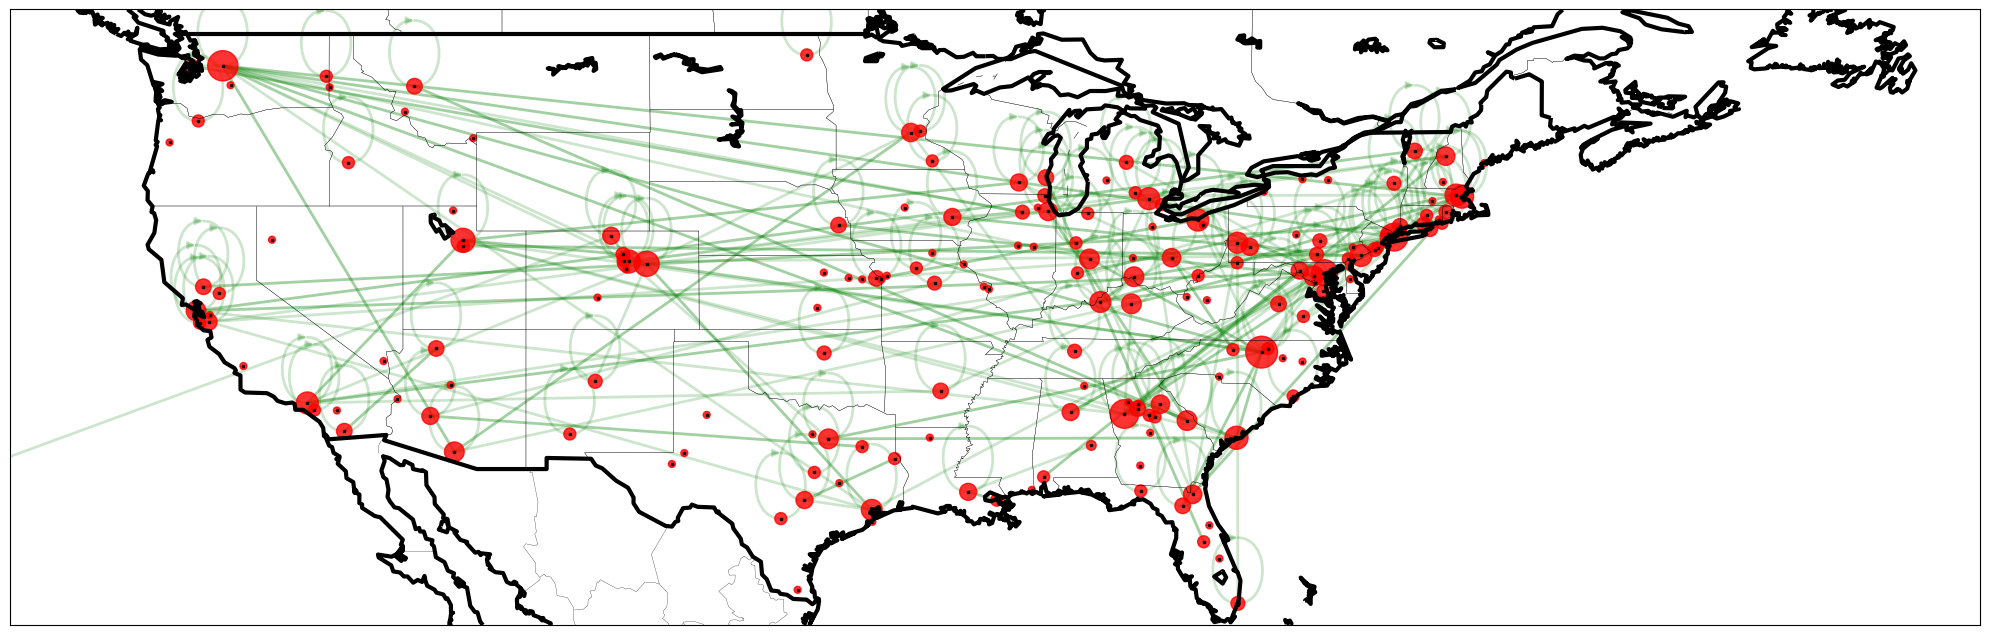

In [ ]:
from mpl_toolkits.basemap import Basemap as Basemap
plt.figure(figsize = (20,9))
m = Basemap(
         #projection='merc',   'mill',  'cyl'
         llcrnrlon=-130,    #-180,  left
         llcrnrlat=25,         #   10,  south
         urcrnrlon=-50,   #-50, right
         urcrnrlat=50,    #70,  North
         lat_ts=0,
         resolution='l',     #   c - crude,  l - low,  h - high,  f - full
         suppress_ticks=True)

mx, my = m(pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,  pd.to_numeric(fip_finding['lat'], downcast='float').values)

############ Counties
#mx, my = m(pd.to_numeric(fip_finding['lng'].str.replace('–', '-', regex=True), downcast='float').values,  pd.to_numeric(fip_finding['lat'], downcast='float').values)
pos = {}

fip_finding['county_fips'] = fip_finding['county_fips'].astype(str)
fip_finding['county_fips'] = fip_finding['county_fips'].apply(lambda x: '{0:0>5}'.format(x))

for count, elem in enumerate (fip_finding['county_fips'].values):
      pos[elem] = (mx[count], my[count])


#pos=nx.spring_layout(G)
d = nx.degree(G)
d = [(d[node]+1) * 25 for node in G.nodes()]
nx.draw_networkx_nodes(G , pos = pos, node_color = 'r', alpha = 0.8, node_size=d) #node_size = 4)
nx.draw_networkx_edges(G , pos = pos, edge_color='g',alpha=0.2, arrows = False, width=2)



####### Utilities
#mx1, my1 = m(pd.to_numeric(Fips_latlong_utility['Longitude'].str.replace('–', '-', regex=True), downcast='float').values,  pd.to_numeric(Fips_latlong_utility['Latitude'], downcast='float').values)
pos1 = {}
#for count, elem in enumerate (Fips_latlong_utility['Utility Number'].values):
#       pos1[elem] = (mx[count], my[count])
n=0
while n<len(Node_utility):
  pos1[Node_utility[n]] = (Log_utlity[n],Lat_utlity[n])
  n+=1

dd = List*1
nx.draw_networkx_nodes(G_utility , pos = pos1,node_shape ='s' , node_color = 'k', alpha = 0.8,node_size=1) #node_size = 4,   node_shape  'so^>v<dph8'
#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')


m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
#m.drawcounties(color='darkred')
#m.bluemarble()
#m.etopo()

plt.tight_layout()
#plt.savefig("/content/drive/Shareddrives/MY Files/Utility-based /map_1.png", format = "png", dpi = 300)
plt.show()

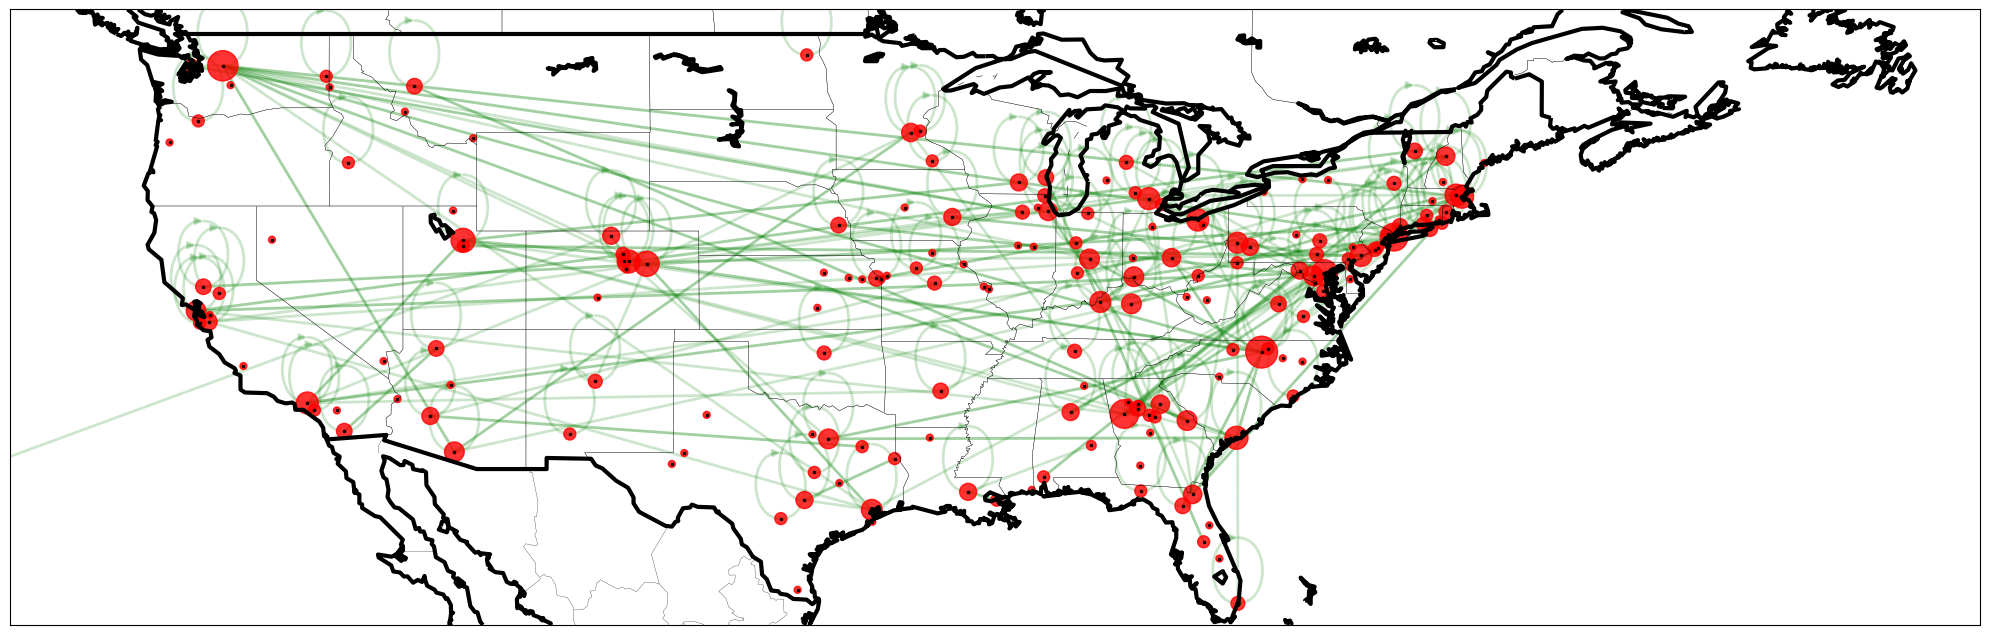

In [ ]:
from mpl_toolkits.basemap import Basemap as Basemap
plt.figure(figsize = (20,9))
m = Basemap(
         #projection='merc',   'mill',  'cyl'
         llcrnrlon=-130,    #-180,  left
         llcrnrlat=25,         #   10,  south
         urcrnrlon=-50,   #-50, right
         urcrnrlat=50,    #70,  North
         lat_ts=0,
         resolution='l',     #   c - crude,  l - low,  h - high,  f - full
         suppress_ticks=True)

mx, my = m(pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,  pd.to_numeric(fip_finding['lat'], downcast='float').values)

############ Counties
#mx, my = m(pd.to_numeric(fip_finding['lng'].str.replace('–', '-', regex=True), downcast='float').values,  pd.to_numeric(fip_finding['lat'], downcast='float').values)
pos = {}

fip_finding['county_fips'] = fip_finding['county_fips'].astype(str)
fip_finding['county_fips'] = fip_finding['county_fips'].apply(lambda x: '{0:0>5}'.format(x))

for count, elem in enumerate (fip_finding['county_fips'].values):
      pos[elem] = (mx[count], my[count])


#pos=nx.spring_layout(G)
d = nx.degree(G)
d = [(d[node]+1) * 25 for node in G.nodes()]
nx.draw_networkx_nodes(G , pos = pos, node_color = 'r', alpha = 0.8, node_size=d) #node_size = 4)
nx.draw_networkx_edges(G , pos = pos, edge_color='g',alpha=0.2, arrows = False, width=2)



####### Utilities
#mx1, my1 = m(pd.to_numeric(Fips_latlong_utility['Longitude'].str.replace('–', '-', regex=True), downcast='float').values,  pd.to_numeric(Fips_latlong_utility['Latitude'], downcast='float').values)
pos1 = {}
#for count, elem in enumerate (Fips_latlong_utility['Utility Number'].values):
#       pos1[elem] = (mx[count], my[count])
n=0
while n<len(Node_utility):
  pos1[Node_utility[n]] = (Log_utlity[n],Lat_utlity[n])
  n+=1

dd = List*1
nx.draw_networkx_nodes(G_utility , pos = pos1,node_shape ='s' , node_color = 'k', alpha = 0.8,node_size=1) #node_size = 4,   node_shape  'so^>v<dph8'
#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')


m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
#m.drawcounties(color='darkred')
#m.bluemarble()
#m.etopo()

plt.tight_layout()
#plt.savefig("/content/drive/Shareddrives/MY Files/Utility-based /map_1.png", format = "png", dpi = 300)
plt.show()

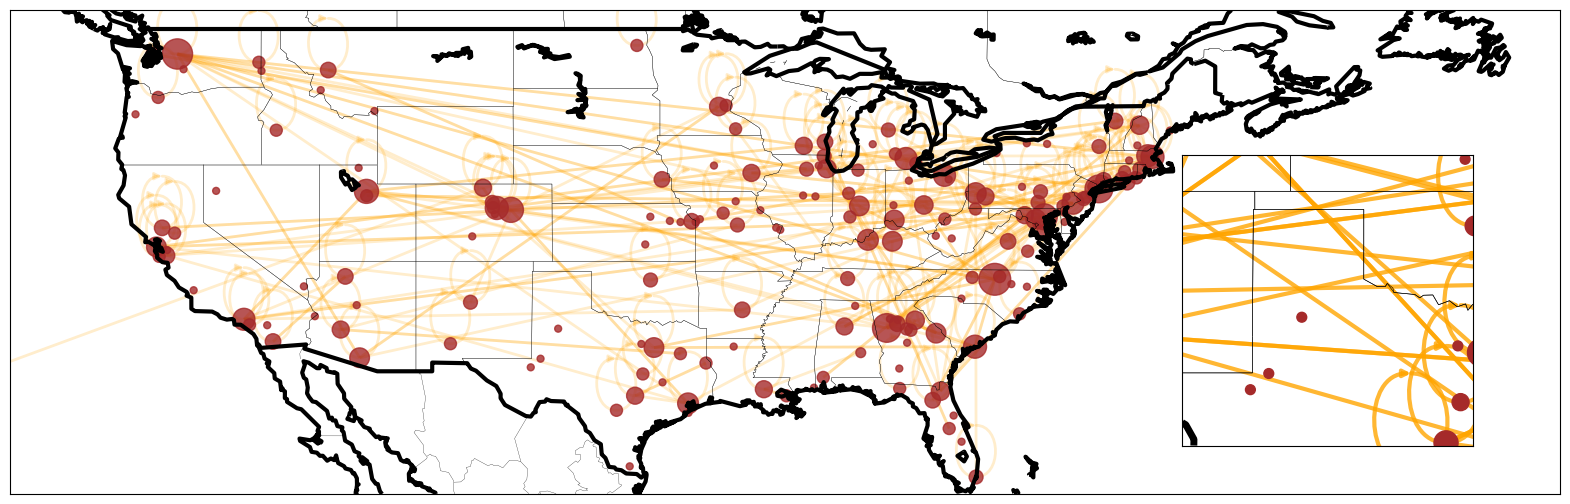

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import networkx as nx
import pandas as pd
from matplotlib.patches import FancyArrowPatch, Rectangle
color_='blue'
# Create main map
plt.figure(figsize=(20, 9))

# Basemap setup for original map
m = Basemap(
    llcrnrlon=-130,  # left
    llcrnrlat=25,    # south
    urcrnrlon=-50,   # right
    urcrnrlat=50,    # north
    lat_ts=0,
    resolution='l',  # low resolution
    suppress_ticks=True
)

# Example of plotting data points (like nodes or counties)
mx, my = m(pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,
           pd.to_numeric(fip_finding['lat'], downcast='float').values)

# Network plotting for nodes and edges (adjust to your own dataset)
pos = {}
fip_finding['county_fips'] = fip_finding['county_fips'].astype(str)
fip_finding['county_fips'] = fip_finding['county_fips'].apply(lambda x: '{0:0>5}'.format(x))

for count, elem in enumerate(fip_finding['county_fips'].values):
    pos[elem] = (mx[count], my[count])

# Degree calculation for node sizes
d = nx.degree(G)
d = [(d[node] + 1) * 25 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=pos, node_color='brown', alpha=0.8, node_size=d)
nx.draw_networkx_edges(G, pos=pos, edge_color='orange', alpha=0.2, arrows=False, width=2)

# Draw map boundaries and features
m.drawcountries(linewidth=3)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=3)

# Create inset map using Axes.inset_axes
ax_inset = plt.gca().inset_axes([0.6, 0.1, 0.5, 0.6])  # x, y, width, height (as a fraction of the main map size)
m_inset = Basemap(
    llcrnrlon=-105,  # Adjust the longitude of the zoomed-in area
    llcrnrlat=30,    # Adjust the latitude of the zoomed-in area
    urcrnrlon=-97,   # Adjust the longitude of the zoomed-in area
    urcrnrlat=38,    # Adjust the latitude of the zoomed-in area
    lat_ts=0,
    resolution='l',
    suppress_ticks=True,
    ax=ax_inset
)

# Draw the zoomed-in map with the same features (you can customize as needed)
m_inset.drawcountries(linewidth=5)
m_inset.drawstates(linewidth=0.4)
m_inset.drawcoastlines(linewidth=5)

# Optionally, add the same points or network on the inset map if you want to highlight the zoomed-in area.
mx_inset, my_inset = m_inset(pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,
                             pd.to_numeric(fip_finding['lat'], downcast='float').values)


# Plot on the inset map
d = nx.degree(G)
d = [(d[node] + 1) * 50 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=pos, node_color='brown', alpha=1, node_size=d, ax=ax_inset)
nx.draw_networkx_edges(G, pos=pos, edge_color='orange', alpha=0.8, arrows=False, width=3, ax=ax_inset)


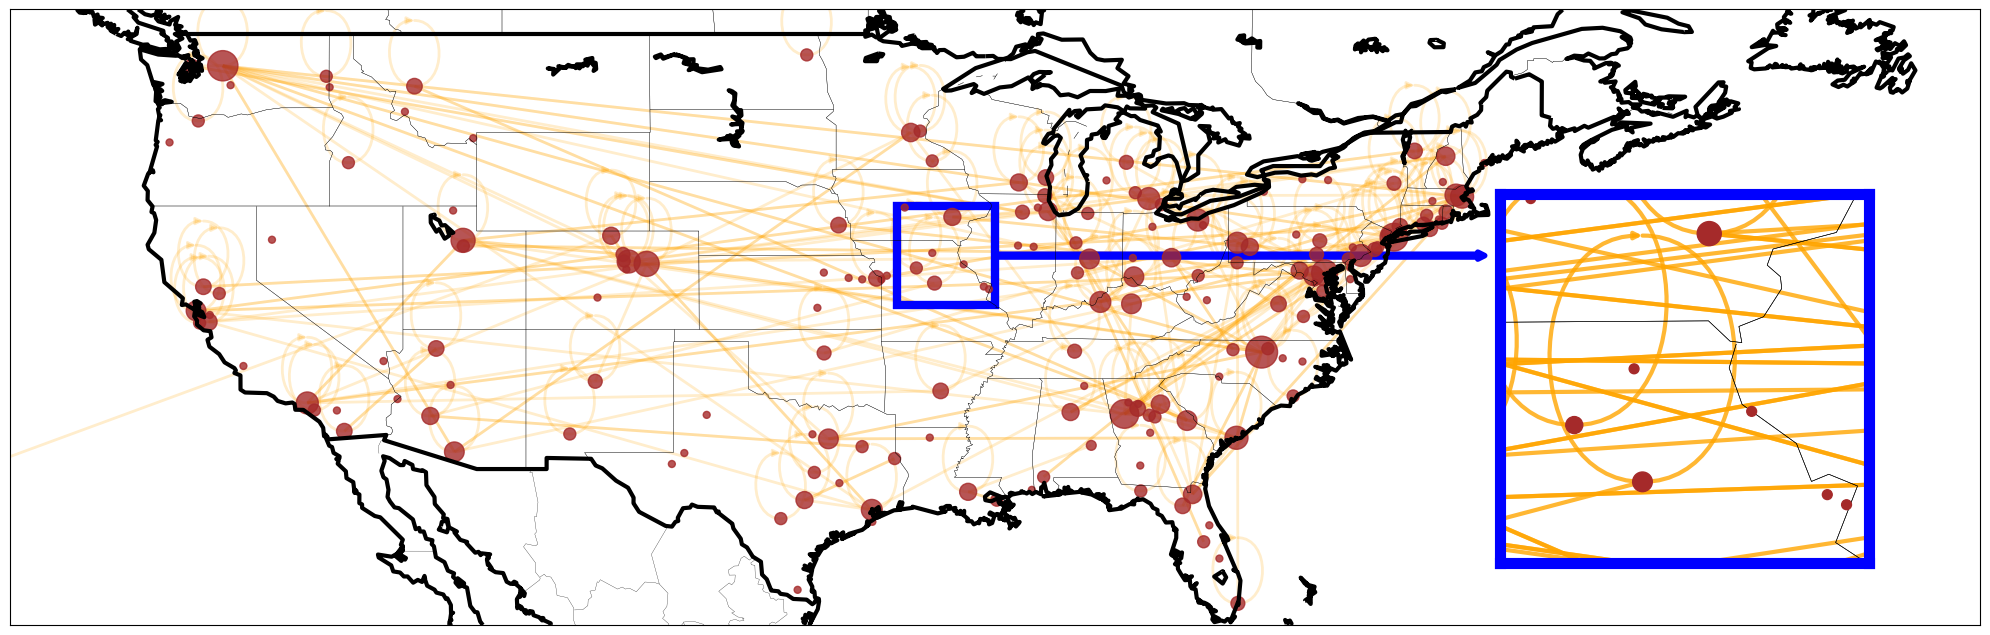

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import networkx as nx
import pandas as pd
from matplotlib.patches import FancyArrowPatch, Rectangle
color_='blue'
# Create main map
plt.figure(figsize=(20, 9))

# Basemap setup for original map
m = Basemap(
    llcrnrlon=-130,  # left
    llcrnrlat=25,    # south
    urcrnrlon=-50,   # right
    urcrnrlat=50,    # north
    lat_ts=0,
    resolution='l',  # low resolution
    suppress_ticks=True
)

# Example of plotting data points (like nodes or counties)
mx, my = m(pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,
           pd.to_numeric(fip_finding['lat'], downcast='float').values)

# Network plotting for nodes and edges (adjust to your own dataset)
pos = {}
fip_finding['county_fips'] = fip_finding['county_fips'].astype(str)
fip_finding['county_fips'] = fip_finding['county_fips'].apply(lambda x: '{0:0>5}'.format(x))

for count, elem in enumerate(fip_finding['county_fips'].values):
    pos[elem] = (mx[count], my[count])

# Degree calculation for node sizes
d = nx.degree(G)
d = [(d[node] + 1) * 25 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=pos, node_color='brown', alpha=0.8, node_size=d)
nx.draw_networkx_edges(G, pos=pos, edge_color='orange', alpha=0.2, arrows=False, width=2)

# Draw map boundaries and features
m.drawcountries(linewidth=3)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=3)

x_,y_=-90,  40 #-101,32

# Create inset map using Axes.inset_axes
ax_inset = plt.gca().inset_axes([0.6, 0.1, 0.5, 0.6])  # x, y, width, height (as a fraction of the main map size)
m_inset = Basemap(
    llcrnrlon= x_-4,  # Adjust the longitude of the zoomed-in area
    llcrnrlat=y_-2,    # Adjust the latitude of the zoomed-in area
    urcrnrlon= x_+0 ,#4,   # Adjust the longitude of the zoomed-in area
    urcrnrlat=y_+2 ,#6,    # Adjust the latitude of the zoomed-in area
    lat_ts=0,
    resolution='l',
    suppress_ticks=True,
    ax=ax_inset
)

# Draw the zoomed-in map with the same features (you can customize as needed)
m_inset.drawcountries(linewidth=5)
m_inset.drawstates(linewidth=0.4)
m_inset.drawcoastlines(linewidth=5)

# Optionally, add the same points or network on the inset map if you want to highlight the zoomed-in area.
mx_inset, my_inset = m_inset(pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,
                             pd.to_numeric(fip_finding['lat'], downcast='float').values)

# Plot on the inset map
d = nx.degree(G)
d = [(d[node] + 1) * 50 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=pos, node_color='brown', alpha=1, node_size=d, ax=ax_inset)
nx.draw_networkx_edges(G, pos=pos, edge_color='orange', alpha=0.8, arrows=False, width=3, ax=ax_inset)

# Change the border line width of the inset map
ax_inset.spines['top'].set_linewidth(8)  # Change top border line width
ax_inset.spines['right'].set_linewidth(8)  # Change right border line width
ax_inset.spines['left'].set_linewidth(8)  # Change left border line width
ax_inset.spines['bottom'].set_linewidth(8)  # Change bottom border line width

# Optionally, change the color of the border line
ax_inset.spines['top'].set_edgecolor(color_)  # Set border color (top)
ax_inset.spines['right'].set_edgecolor(color_)  # Set border color (right)
ax_inset.spines['left'].set_edgecolor(color_)  # Set border color (left)
ax_inset.spines['bottom'].set_edgecolor(color_)  # Set border color (bottom)




# Add arrow pointing from the zoomed-in region on the main map to the inset
arrow = FancyArrowPatch(
    posA=(x_, y_),  # Starting position on the main map (x, y)
    posB=(-70, 40),  # Ending position on the inset map (x, y)
    #connectionstyle="arc3,rad=0.1",  # Arc-style arrow
    color=color_,  # Arrow color
    #arrowstyle='->',  # Arrow style
    mutation_scale=10,  # Scale of the arrow
    lw=4  # Line width of the arrow
)

plt.gca().add_patch(arrow)  # Add the arrow to the plot

# Draw a rectangle on the main map to highlight the zoomed-in area
rect = Rectangle(
    (x_-4, y_-2),  # bottom-left corner of the zoomed-in area
    4,  # width (difference between urcrnrlon and llcrnrlon)
    4,  # height (difference between urcrnrlat and llcrnrlat)
    linewidth=6,  # line width
    edgecolor=color_,  # rectangle color
    facecolor='none'  # no fill
    #linestyle='--'  # dashed line style
)
plt.gca().add_patch(rect)  # Add the rectangle to the plot

plt.tight_layout()
plt.show()

<ipython-input-86-9e7dc3b9750c>:99: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


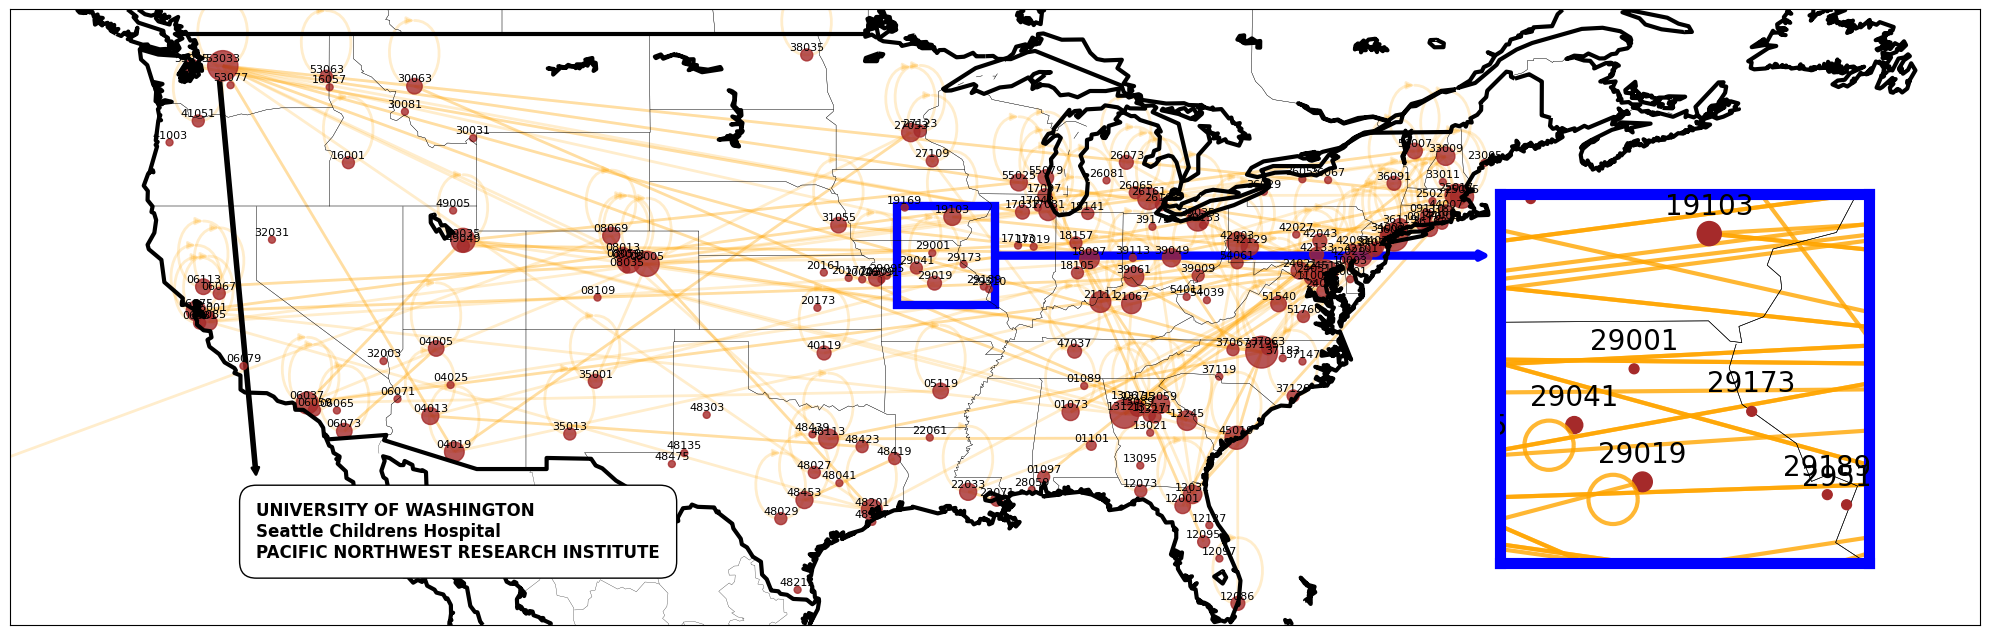

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import networkx as nx
import pandas as pd
from matplotlib.patches import FancyArrowPatch, Rectangle

color_ = 'blue'

# Create main map
plt.figure(figsize=(20, 9))

# Basemap setup for original map
m = Basemap(
    llcrnrlon=-130,  # left
    llcrnrlat=25,    # south
    urcrnrlon=-50,   # right
    urcrnrlat=50,    # north
    lat_ts=0,
    resolution='l',  # low resolution
    suppress_ticks=True
)

# Example of plotting data points (like nodes or counties)
# Ensure that your DataFrame 'fip_finding' is already loaded and that 'lng' and 'lat' exist.
mx, my = m(
    pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,
    pd.to_numeric(fip_finding['lat'], downcast='float').values
)

# Network plotting for nodes and edges (adjust to your own dataset)
pos = {}
fip_finding['county_fips'] = fip_finding['county_fips'].astype(str)
fip_finding['county_fips'] = fip_finding['county_fips'].apply(lambda x: '{0:0>5}'.format(x))

for count, elem in enumerate(fip_finding['county_fips'].values):
    pos[elem] = (mx[count], my[count])

# Calculate node sizes based on degree
d = nx.degree(G)
node_sizes = [(d[node] + 1) * 25 for node in G.nodes()]

# Draw nodes and edges on the main map
nx.draw_networkx_nodes(G, pos=pos, node_color='brown', alpha=0.8, node_size=node_sizes)
nx.draw_networkx_edges(G, pos=pos, edge_color='orange', alpha=0.2, arrows=False, width=2)

# *** Add labels for the nodes using their FIPS codes ***
# Create a labels dictionary: key = node, value = FIPS code (or any label you prefer)
labels = {node: node for node in G.nodes()}
offset = 0.3  # Adjust offset value according to your map's coordinate scale
# Create a new dictionary for label positions (labels will be drawn above the nodes)
label_pos = {node: (x, y + offset) for node, (x, y) in pos.items()}

nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='black')
# *** End of label addition ***

# Draw map boundaries and features
m.drawcountries(linewidth=3)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=3)

# Coordinates for the zoomed area
x_, y_ = -90, 40

# Create inset map using Axes.inset_axes
ax_inset = plt.gca().inset_axes([0.6, 0.1, 0.5, 0.6])  # x, y, width, height (as fraction of main map size)
m_inset = Basemap(
    llcrnrlon=x_ - 4,  # Adjust the longitude of the zoomed-in area
    llcrnrlat=y_ - 2,  # Adjust the latitude of the zoomed-in area
    urcrnrlon=x_ + 0,  # Adjust the longitude of the zoomed-in area
    urcrnrlat=y_ + 2,  # Adjust the latitude of the zoomed-in area
    lat_ts=0,
    resolution='l',
    suppress_ticks=True,
    ax=ax_inset
)

# Draw the zoomed-in map features
m_inset.drawcountries(linewidth=5)
m_inset.drawstates(linewidth=0.4)
m_inset.drawcoastlines(linewidth=5)

# Plot nodes and edges on the inset map
mx_inset, my_inset = m_inset(
    pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,
    pd.to_numeric(fip_finding['lat'], downcast='float').values
)
# Adjust node sizes for the inset (if desired)
node_sizes_inset = [(d[node] + 1) * 50 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos=pos, node_color='brown', alpha=1, node_size=node_sizes_inset, ax=ax_inset)


self_loops = [(u, v) for u, v in G.edges() if u == v]
normal_edges = [(u, v) for u, v in G.edges() if u != v]
#nx.draw_networkx_edges(G, pos=pos, edge_color='orange', alpha=0.8, arrows=False, width=3, ax=ax_inset)
nx.draw_networkx_edges(G, pos=pos, edgelist=normal_edges, edge_color='orange', alpha=0.8, arrows=False, width=3, ax=ax_inset)
# Draw self-loops with a custom (smaller) curvature.
# The connectionstyle parameter "arc3, rad=0.1" will make the self-loop drawn as a smaller arc.
if self_loops:
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=self_loops,
        edge_color='orange',
        alpha=0,
        arrows=False,
        width=3,
        connectionstyle='arc3, rad=0.01',
         ax=ax_inset
    )




# *** Add labels to the inset map as well ***
nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=20, font_color='black', ax=ax_inset)
# *** End of inset label addition ***

# Change the border line width and color of the inset map
for spine in ax_inset.spines.values():
    spine.set_linewidth(8)
    spine.set_edgecolor(color_)

# Add an arrow pointing from the zoomed-in region on the main map to the inset
arrow = FancyArrowPatch(
    posA=(x_, y_),      # Starting position on the main map
    posB=(-70, 40),     # Ending position on the inset map
    color=color_,
    mutation_scale=10,  # Scale of the arrow
    lw=4              # Line width of the arrow
)
plt.gca().add_patch(arrow)


arrow = FancyArrowPatch(
    posA=(-121.5, 47.2),      # Starting position on the main map
    posB=(-120, 31),     # Ending position on the inset map
    color='black',
    mutation_scale=10,  # Scale of the arrow
    lw=2              # Line width of the arrow
)
plt.gca().add_patch(arrow)


text_str = (
    "UNIVERSITY OF WASHINGTON\n"
    "Seattle Childrens Hospital\n"
    "PACIFIC NORTHWEST RESEARCH INSTITUTE"
)

# Convert the lon/lat position (-126, 38) to map coordinates.
x_text, y_text = m(-120, 30)

# Add the text box to the map.
plt.text(
    x_text, y_text, text_str,
    fontsize=12, fontweight="bold", color="black",
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
    horizontalalignment='left',  # adjust as needed (e.g., 'center')
    verticalalignment='top'      # ensures the text box is anchored at the top
)

# Draw a rectangle on the main map to highlight the zoomed-in area
rect = Rectangle(
    (x_ - 4, y_ - 2),  # bottom-left corner of the zoomed-in area
    4,                 # width
    4,                 # height
    linewidth=6,       # line width
    edgecolor=color_,  # rectangle color
    facecolor='none'   # no fill
)
plt.gca().add_patch(rect)


import matplotlib.patches as mpatches
import math
#29041
x, y = pos['29019']
x,y=-64.9,30.1
loop_radius = 1 # This is in map coordinates; adjust for your scale.
theta1, theta2 = 0, 360  # Full circle
# Create an arc (or full circle) patch centered on the node
loop_patch = mpatches.Arc((x, y), width=2*loop_radius, height=2*loop_radius,
                           angle=0, theta1=theta1, theta2=theta2,
                           edgecolor='orange', lw=3, alpha=0.8, zorder=100  )
plt.gca().add_patch(loop_patch)

x,y=-67.5,32.3
loop_radius = 1 # This is in map coordinates; adjust for your scale.
theta1, theta2 = 0, 360  # Full circle
# Create an arc (or full circle) patch centered on the node
loop_patch = mpatches.Arc((x, y), width=2*loop_radius, height=2*loop_radius,
                           angle=0, theta1=theta1, theta2=theta2,
                           edgecolor='orange', lw=3, alpha=0.8, zorder=100  )
plt.gca().add_patch(loop_patch)

plt.tight_layout()
plt.show()

<ipython-input-54-e2f36126a293>:53: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


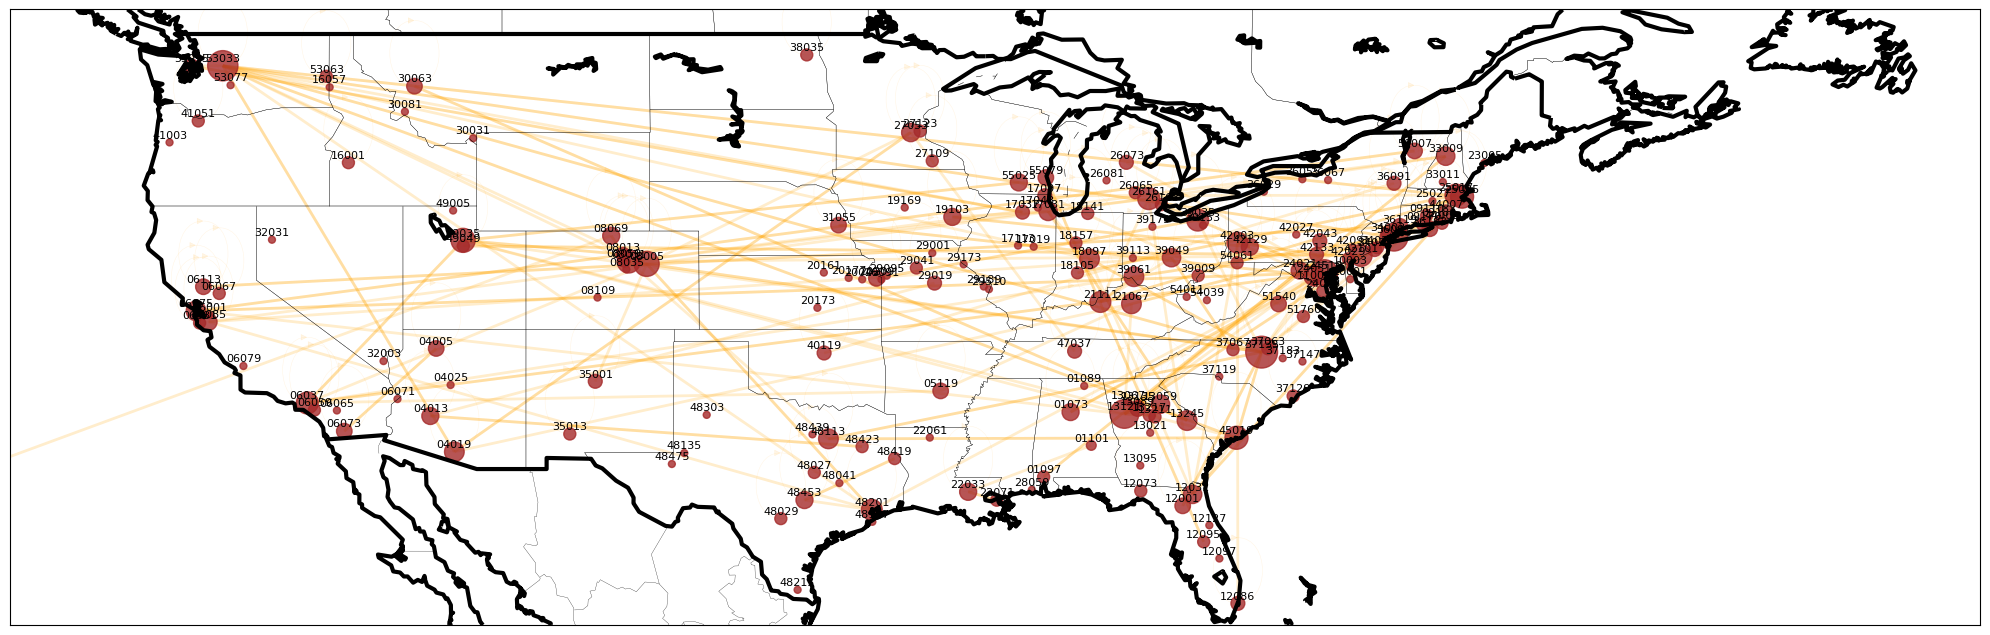

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import networkx as nx
import pandas as pd
from matplotlib.patches import FancyArrowPatch, Rectangle

color_ = 'blue'

# Create main map
plt.figure(figsize=(20, 9))

# Basemap setup for original map
m = Basemap(
    llcrnrlon=-130,  # left
    llcrnrlat=25,    # south
    urcrnrlon=-50,   # right
    urcrnrlat=50,    # north
    lat_ts=0,
    resolution='l',  # low resolution
    suppress_ticks=True
)

# Example of plotting data points (like nodes or counties)
mx, my = m(
    pd.to_numeric(fip_finding['lng'].astype(str).str.replace('–', '-', regex=True), downcast='float').values,
    pd.to_numeric(fip_finding['lat'], downcast='float').values
)

# Network plotting for nodes and edges
pos = {}
fip_finding['county_fips'] = fip_finding['county_fips'].astype(str)
fip_finding['county_fips'] = fip_finding['county_fips'].apply(lambda x: '{0:0>5}'.format(x))
for count, elem in enumerate(fip_finding['county_fips'].values):
    pos[elem] = (mx[count], my[count])

# Calculate node sizes based on degree
d = nx.degree(G)
node_sizes = [(d[node] + 1) * 25 for node in G.nodes()]

# Draw nodes
nx.draw_networkx_nodes(G, pos=pos, node_color='brown', alpha=0.8, node_size=node_sizes)

# Separate self-loop edges from normal edges
self_loops = [(u, v) for u, v in G.edges() if u == v]
normal_edges = [(u, v) for u, v in G.edges() if u != v]

# Draw normal edges normally
nx.draw_networkx_edges(G, pos=pos, edgelist=normal_edges, edge_color='orange', alpha=0.2, arrows=False, width=2)

# Draw self-loops with a custom (smaller) curvature.
# The connectionstyle parameter "arc3, rad=0.1" will make the self-loop drawn as a smaller arc.
if self_loops:
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=self_loops,
        edge_color='orange',
        alpha=0.1,
        arrows=False,
        width=0.4,
        connectionstyle='arc3, rad=0.01'
    )

# Add labels for the nodes (with a little offset)
labels = {node: node for node in G.nodes()}
offset = 0.3  # Adjust as needed (this value depends on your coordinate scale)
label_pos = {node: (x, y + offset) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='black')

# Draw map boundaries and features
m.drawcountries(linewidth=3)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=3)

# [Rest of your code for inset map, additional arrows, text box, etc.]

plt.tight_layout()
plt.show()

In [ ]:
53033

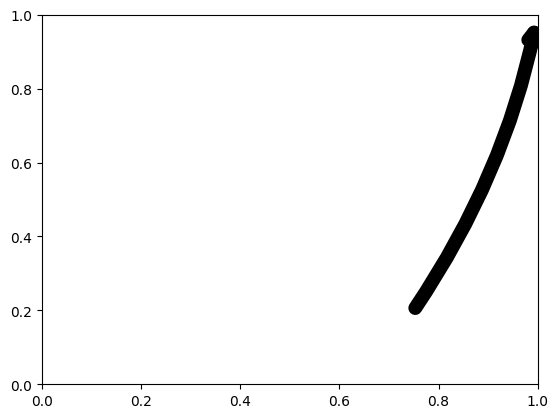

In [ ]:
arrow = FancyArrowPatch(
    posA=(0.75, 0.2),  # Starting position on the main map (x, y)
    posB=(1, 1),  # Ending position on the inset map (x, y)
    connectionstyle="arc3,rad=0.1",  # Arc-style arrow
    color='black',  # Arrow color
    arrowstyle='->',  # Arrow style
    mutation_scale=15,  # Scale of the arrow
    lw=10  # Line width of the arrow
)

plt.gca().add_patch(arrow)  # Add the arrow to the plot
plt.show()

In [ ]:
G=nx.Graph()
G.add_nodes_from(Node)
G.add_edges_from(Edge)

###########################################################  Cliques ###################################
cl=nx.enumerate_all_cliques(G)
#print last 10 cliques
print([l for l in cl][-10:])
#"5 Largest Cliques"
print("5 Largest Cliques",sorted([l for l in nx.find_cliques(G)],key=lambda x: len(x),reverse=True)[:5])

##################################################### PAGERANK and HITS  ###################################
pg_rank=sorted([l for l in nx.pagerank(G).items()],key=lambda x: x[1],reverse=True)
print("Top 10 county By Pagerank",pg_rank[:10])

hubs,authorities=nx.hits(G)
hubs=sorted([l for l in hubs.items()],key=lambda x: x[1],reverse=True)
authorities=sorted([l for l in authorities.items()],key=lambda x: x[1],reverse=True)
print("Top 10 Biggest Hubs",hubs[:10])
print("\nTop 10 Biggest Authorities",authorities[:10])


[['37135', '36081', '53033'], ['37135', '53033', '08005'], ['37135', '53033', '45019'], ['37135', '24510', '39035'], ['37135', '45019', '48113'], ['36081', '21067', '13121'], ['53033', '48201', '08005'], ['53033', '08005', '08031'], ['53033', '17037', '53035'], ['33009', '26161', '08031']]
5 Largest Cliques [['37135', '25017', '36081'], ['37135', '39035', '24510'], ['37135', '48113', '45019'], ['37135', '49035', '45019'], ['37135', '53033', '18097']]
Top 10 county By Pagerank [('37135', 0.02110846025003433), ('13121', 0.020700699559702888), ('53033', 0.019897065003184396), ('36081', 0.015850258025635253), ('08005', 0.015522269088957099), ('42101', 0.015127183042805435), ('24510', 0.014452121084169645), ('08031', 0.014280216416445474), ('22033', 0.013892528917574006), ('25017', 0.013692734184358415)]
Top 10 Biggest Hubs [('37135', 0.07607062363092737), ('53033', 0.06779268998715758), ('08005', 0.047761612577652525), ('36081', 0.04664672162719216), ('45019', 0.04064022953701027), ('49035

In [ ]:
len(G.nodes)

181

0

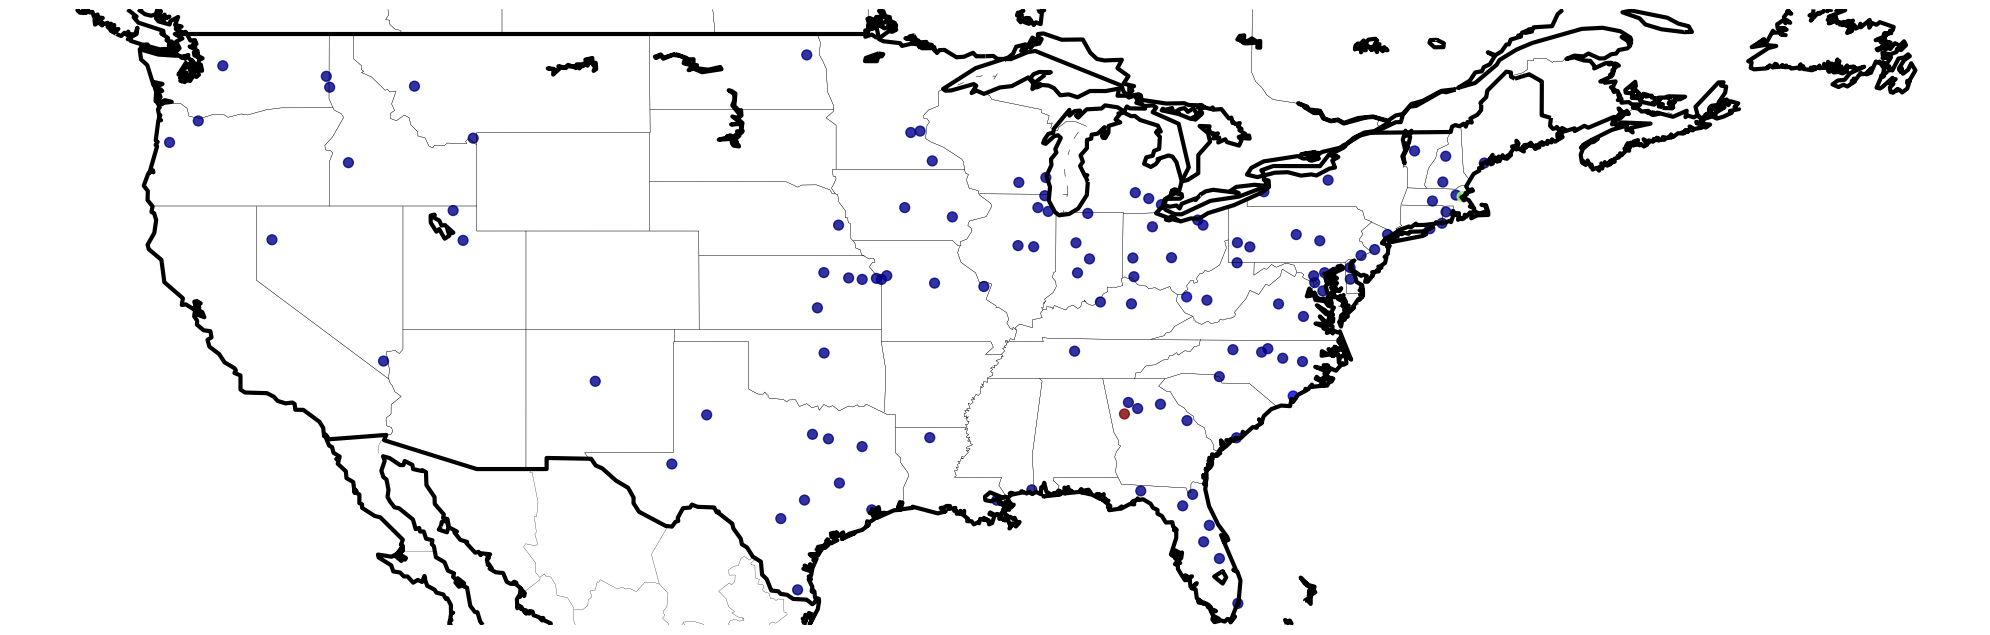

In [ ]:
############################  Communty Detection  ######################
import community #requires separate install -  pip install python-louvain
from community import community_louvain
import warnings

plt.figure(figsize=(20,9))
#partition = community_louvain.best_partition(G)
cluster_info = {str(key): value for key, value in cluster_info.items()}
partition= cluster_info
nodes_to_remove = [node for node, attr in G.nodes(data=True) if node not in cluster_info]
display(len(nodes_to_remove))
for node in nodes_to_remove:
    if node in G:
        G.remove_node(node)
values = [partition.get(node) for node in G.nodes()]

pos = {}

fip_finding['county_fips'] = fip_finding['county_fips'].astype(str)
fip_finding['county_fips'] = fip_finding['county_fips'].apply(lambda x: '{0:0>5}'.format(x))

for count, elem in enumerate (fip_finding['county_fips'].values):
      pos[elem] = (mx[count], my[count])



#####################################################################


plt.axis("off")
#plt.title('Social Network'.format(len(set(partition.values()))))
#nx.draw_networkx(Gc, pos = pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 1, with_labels = False)


nx.draw_networkx_nodes(G , pos = pos, cmap = plt.get_cmap("jet"), node_color = values, alpha = 0.8, node_size=50) #node_size = 4)
#nx.draw_networkx_edges(G , pos = pos, edge_color='k',alpha=0.2, arrows = False,width=5)


m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
#m.drawcounties(color='darkred')
#m.bluemarble()
#m.etopo()

plt.tight_layout()
plt.show()